<a href="https://colab.research.google.com/github/DARSHITA2804/DEEPLEARNING/blob/main/lab15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision


In [ ]:
# ✅ Check what’s already available
import torch, torchvision
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)

# ✅ Optional: install matplotlib (for plotting)
!pip install matplotlib --quiet


Torch: 2.8.0+cu126
TorchVision: 0.23.0+cu126


In [ ]:
# Simple YOLO on FakeData (Colab-ready)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SimpleYOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        super(SimpleYOLO, self).__init__()
        self.S, self.B, self.C = S, B, C
        self.features = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        # Calculate the input size for the fully connected layer dynamically
        # based on the output shape of the convolutional layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            dummy_output = self.features(dummy_input)
            fc_input_size = dummy_output.view(dummy_output.size(0), -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_size, 256), nn.ReLU(),
            nn.Linear(256, S*S*(B*5 + C))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x.view(-1, self.S, self.S, self.B*5 + self.C)

def get_fake_dataset(img_size=224, num_classes=3, size=200):
    tf = transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()])
    return datasets.FakeData(size=size, image_size=(3,img_size,img_size),
                             num_classes=num_classes, transform=tf)

def train_simple_yolo():
    S,B,C = 7,2,3
    model = SimpleYOLO(S,B,C)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    data = DataLoader(get_fake_dataset(num_classes=C), batch_size=8, shuffle=True)

    for epoch in range(3):
        for imgs,_ in data:
            preds = model(imgs)
            loss = loss_fn(preds, torch.zeros_like(preds))
            opt.zero_grad(); loss.backward(); opt.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    torch.save(model.state_dict(), "simple_yolo_fake.pth")
    print("✅ Done!"); return model

model = train_simple_yolo()

# Test prediction
x = torch.rand(1,3,224,224)
with torch.no_grad(): y = model(x)
print("Output shape:", y.shape)

Epoch 1: Loss = 0.0006
Epoch 2: Loss = 0.0000
Epoch 3: Loss = 0.0000
✅ Done!
Output shape: torch.Size([1, 7, 7, 13])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 448x640 1 car, 322.2ms
Speed: 34.0ms preprocess, 322.2ms inference, 32.6ms postprocess per image at shape (1, 3, 448, 640)


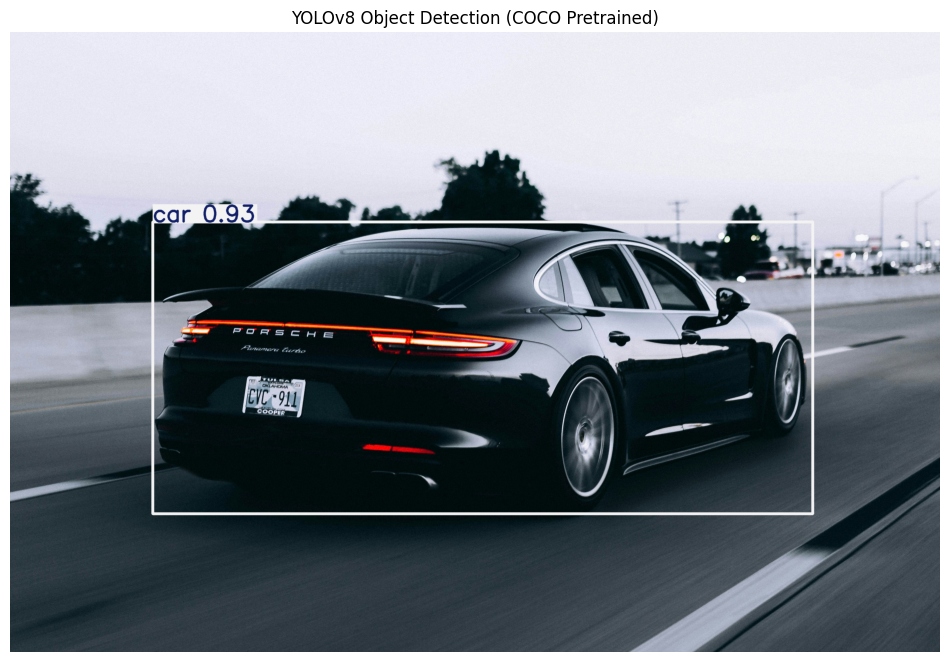

In [ ]:
# 1. Install dependencies
# We only need 'ultralytics' (which includes torch) and 'matplotlib'
!pip install ultralytics matplotlib --quiet

# 2. Import libraries
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import requests
import io # Needed for handling image from requests

# 3. Load pretrained YOLO model
# We'll use YOLOv8n (nano), which is fast and COCO-pretrained.
model = YOLO('yolov8n.pt')

# 4. Load a sample image from URL
url = "https://images.unsplash.com/photo-1503376780353-7e6692767b70" # has cars
img = None
try:
    # Get the image data
    response = requests.get(url)
    response.raise_for_status() # Raise an error for bad responses

    # Open the image from the in-memory bytes
    img = Image.open(io.BytesIO(response.content)).convert("RGB")

except Exception as e:
    print(f"Could not load image from URL. Error: {e}")
    # Create a dummy image if loading fails
    img = Image.new('RGB', (800, 600), color='gray')

# 5. Run Prediction
# YOLO handles all preprocessing (transforms, ToTensor) automatically.
# We set 'conf=0.7' to match the original code's confidence threshold.
results = model(img, conf=0.7)

# 6. Visualize Detections
# The 'results' object has a built-in .plot() method!
# This method draws the boxes and labels directly on the image.

# Get the first (and only) result
result = results[0]

# .plot() returns a NumPy array of the image with boxes, in BGR format
img_with_boxes_bgr = result.plot()

# Convert from BGR (OpenCV format) to RGB (matplotlib format)
img_with_boxes_rgb = img_with_boxes_bgr[..., ::-1]

# Display the image
fig, ax = plt.subplots(figsize=(12, 9))
ax.imshow(img_with_boxes_rgb)
plt.axis("off")
plt.title("YOLOv8 Object Detection (COCO Pretrained)")
plt.show()